In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb

import gzip

import sklearn.preprocessing

from scipy.spatial.distance import cosine


/home/cpage/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
# We split trainfile into train and valid pretty early on
trainfile_orig = pd.read_csv('../walmart-input/train.csv')
trainfile = trainfile_orig.copy()

test_orig = pd.read_csv('../walmart-input/test.csv')
test = test_orig.copy()

sub_orig = pd.read_csv('../walmart-input/sample_submission.csv')
sub = sub_orig.copy()

In [3]:
def chop_triptype(tt):
    return int(tt[9:])

triptype_map = {}
triptypestr_map = {}

c = 0
for k in sub.loc[0].keys():
    if 'TripType_' in k:
        triptypestr_map[k] = c
        triptype_map[chop_triptype(k)] = c
        
        c += 1

triptype_map[45] = triptype_map[999]

print(triptypestr_map)
print(triptype_map)



{'TripType_18': 10, 'TripType_7': 4, 'TripType_8': 5, 'TripType_15': 9, 'TripType_44': 36, 'TripType_28': 20, 'TripType_33': 25, 'TripType_25': 17, 'TripType_5': 2, 'TripType_24': 16, 'TripType_14': 8, 'TripType_38': 30, 'TripType_26': 18, 'TripType_21': 13, 'TripType_22': 14, 'TripType_36': 28, 'TripType_27': 19, 'TripType_43': 35, 'TripType_6': 3, 'TripType_39': 31, 'TripType_999': 37, 'TripType_19': 11, 'TripType_40': 32, 'TripType_34': 26, 'TripType_37': 29, 'TripType_23': 15, 'TripType_30': 22, 'TripType_29': 21, 'TripType_20': 12, 'TripType_12': 7, 'TripType_42': 34, 'TripType_31': 23, 'TripType_35': 27, 'TripType_3': 0, 'TripType_9': 6, 'TripType_4': 1, 'TripType_41': 33, 'TripType_32': 24}
{3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 12: 7, 14: 8, 15: 9, 18: 10, 19: 11, 20: 12, 21: 13, 22: 14, 23: 15, 24: 16, 25: 17, 26: 18, 27: 19, 28: 20, 29: 21, 30: 22, 31: 23, 32: 24, 33: 25, 34: 26, 35: 27, 36: 28, 37: 29, 38: 30, 39: 31, 40: 32, 41: 33, 42: 34, 43: 35, 44: 36, 45: 37, 999: 

In [4]:
# replace days of week.  Yes this could be defined with one line...

dow = {}
dow['Monday'] = 1
dow['Tuesday'] = 2
dow['Wednesday'] = 3
dow['Thursday'] = 4
dow['Friday'] = 5
dow['Saturday'] = 6
dow['Sunday'] = 7

def preproc(df):
    df.Weekday.replace(dow, inplace=True)
    
    df.FinelineNumber.replace({np.nan: -1}, inplace=True)

    df.FinelineNumber = df.FinelineNumber.astype(int)
    df.FinelineNumber += 1

    # there are nan's that need to get converted
    df.DepartmentDescription = df.DepartmentDescription.astype(str)
    
    if 'TripType' in df:
        enc = sklearn.preprocessing.OneHotEncoder()
        enc.fit(df.TripType.reshape(-1, 1))
    
        df.TripTypeOneHot = enc.transform(df.TripType.reshape(-1, 1)).toarray()

# replace type 999 with 45 to keep from wasting memory in structs
#trainfile.TripType.replace({999: 45}, inplace=True)

trainfile.TripType.replace(triptype_map, inplace=True)

preproc(trainfile)
preproc(test)

In [5]:
# Now split the train data into train+valid.  2.5% with seed 0 appears to be pretty good, at least until this
# gets competitive

visits = np.unique(trainfile.VisitNumber)

# determine visits to go in validation set
np.random.seed(0)
validation_visits = np.random.choice(visits, int(len(visits) * .025))

# compute (raw) rows in validation set
validation_set = (trainfile.VisitNumber == validation_visits[0])

for i in range(1, len(validation_visits)):
    validation_set |= trainfile.VisitNumber == validation_visits[i]

valid = trainfile.ix[validation_set]
    
# flip that around to get the train set
training_set = np.invert(validation_set)
train = trainfile.ix[training_set]

In [6]:
# mclogloss.py (todo: copy in original link)
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    idea from this post:
    http://www.kaggle.com/c/emc-data-science/forums/t/2149/is-anyone-noticing-difference-betwen-validation-and-leaderboard-error/12209#post12209

    Parameters
    ----------
    y_true : array, shape = [n_samples]
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(predictions))
    return -1.0 / rows * vsota


In [7]:
def build_visitmaps(df):
    visits = np.unique(df.VisitNumber)
    visitmap = {}

    vtype = np.zeros(len(visits))

    if 'TripType' in df:
        for i in range(0, len(visits)):
            vtype[i] = df.ix[df.VisitNumber == visits[i]].iloc[0].TripType
    
    for i in range(0, len(visits)):
        visitmap[visits[i]] = i
        
    return visits, vtype, visitmap
    
valid_visits, valid_type, valid_visitmap = build_visitmaps(valid)
test_visits, test_type, test_visitmap = build_visitmaps(test)

In [8]:
# make categorical #'s.  TODO: move up to preproc???
ddcat = np.unique(train.DepartmentDescription)

# build map
ddmap = {}
for i in range(0, len(ddcat)):
    ddmap[ddcat[i]] = i
           
# apply map
def makeddint(df):
    ddcatout = np.zeros(len(df.DepartmentDescription))
    for i in range(0, len(ddcat)):
        ddcatout[np.where(df.DepartmentDescription == ddcat[i])] = i
    
    # XXX: this is raising a SettingWithCopyWarning on valid and possibly train
    df['DepartmentDescriptionInt'] = ddcatout.astype(int)
    
    return df

train = makeddint(train)
valid = makeddint(valid)
test = makeddint(test)

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
train_psc = train[train.ScanCount >= 1]
subsetted = np.full(len(train_psc), False, dtype=bool)

enc = sklearn.preprocessing.OneHotEncoder()
enc.fit(train_psc.TripType.reshape(-1, 1))

a = enc.transform(train_psc.TripType.reshape(-1, 1)).toarray()

flmap = {}
flnd = {}

ddmax = np.max(train.DepartmentDescriptionInt) + 1
fnum = ddmax

for cat in range(0, ddmax):
#for cat in [20]:
    catmask = train_psc.DepartmentDescriptionInt == cat
    subset = train_psc[catmask]
    
    #print(cat, len(subset))
    if len(subset) < 25:
        continue
        
#    vc = subset.Upc.value_counts()
    vc = subset.FinelineNumber.value_counts()
    
    for iterit in vc.iteritems():
        fln = iterit[0]
        if (iterit[1] < 20): # or (len(subset) < (iterit[1] * 2)):
            continue
            
        fnum += 1
                
        flmap[(cat, fln)] = fnum
        
print(len(flmap.keys()))
for i in flmap:
    print(i, flmap[i])

4412
(32, 8246) 2291
(5, 2381) 382
(24, 3601) 1429
(43, 2025) 3018
(41, 6167) 2819
(29, 8366) 1989
(11, 90) 530
(25, 6811) 1760
(31, 2018) 2223
(31, 1081) 2194
(50, 7016) 3384
(33, 6304) 2359
(62, 8404) 4210
(17, 9552) 1014
(64, 719) 4322
(3, 2031) 175
(19, 5961) 1203
(57, 4606) 4039
(17, 2505) 1039
(12, 59) 615
(31, 6661) 2157
(40, 1109) 2756
(25, 2361) 1767
(37, 600) 2633
(56, 7562) 3829
(55, 8604) 3798
(33, 6056) 2358
(3, 6707) 197
(57, 5952) 3956
(31, 3091) 2187
(43, 4627) 2894
(2, 1201) 116
(5, 4003) 351
(2, 912) 138
(43, 1105) 2885
(17, 4649) 1127
(28, 1168) 1957
(13, 2286) 669
(34, 3170) 2471
(49, 3553) 3184
(15, 906) 684
(34, 1002) 2406
(24, 3608) 1702
(25, 6013) 1805
(51, 3831) 3465
(64, 8158) 4319
(17, 3664) 1037
(43, 8025) 2998
(17, 3054) 934
(17, 2353) 918
(68, 0) 4481
(12, 821) 618
(5, 4521) 360
(24, 2258) 1557
(51, 7421) 3451
(50, 5016) 3256
(24, 2259) 1613
(4, 1425) 252
(52, 3755) 3648
(34, 716) 2464
(24, 3031) 1553
(24, 3307) 1462
(43, 1081) 2893
(66, 1402) 4383
(12, 12

In [10]:

def make_ddcomb(df, num_visits = 100000000):
    
    num_ents = len(df)
    
    visits = np.sort(np.unique(df.VisitNumber))
    
    num_visits = min(num_visits, len(visits))

    ddmax = np.max(train.DepartmentDescriptionInt)

    mat = np.zeros((num_visits, (ddmax * 2) + fnum + 2))
    tt = np.zeros(num_visits)
 
    df_scancount = df.ScanCount.values
    df_visitnumber = df.VisitNumber.values
    df_triptype = df.TripType.values if ('TripType' in df) else np.zeros(len(df))
    df_ddint = df.DepartmentDescriptionInt.values
    df_fln = df.Upc.values
    df_fln = df.FinelineNumber.values
    #    df_fmap = df.fmap.values
    df_weekday = df.Weekday.values
    
    
    visitmap = {}
    
    vnum = -1
    
    icount = np.zeros(num_visits + 1)
    
    for i in range(0, num_ents):
        try:
            visit = visitmap[df_visitnumber[i]]
        except:
            vnum += 1

            if (vnum + 1) == num_visits:
                break
            
            visitmap[df_visitnumber[i]] = vnum
            visit = vnum
            
            tt[vnum] = df_triptype[i]
#            mat[visit][fnum + 1] = df_weekday[i] >= 6
#            mat[visit][fnum + 2] = df_weekday[i] == 1
#            mat[visit][fnum + df_weekday[i]] = 1
            
        icount[visit] += 1
    
        if True: #df_scancount[i] > 0:
            dept = df_ddint[i]
            fln = df_fln[i]
            
            # allocation space: 
            # 0 - % returns
            # 1 - ddmax - regular map
            # ddmax - ddmax*2 - leftovers
            # ddmax*2 >= +fmap - map
            
            mat[visit][1 + df_ddint[i]] += (1 + ((df_scancount[i] - 1) * .25))
            
            try:
                feature = 1 + (ddmax * 2) + flmap[(dept, fln)]
                mat[visit][feature] += (1 + ((df_scancount[i] - 1) * .25))
            except:
                None
                feature = 1 + ddmax + dept
                mat[visit][feature] += (1 + ((df_scancount[i] - 1) * .25))
                
        if df_scancount[i] < 0:
            mat[visit][0] += 1
            
    vnum += 1
#    for i in range(0, vnum):
#        if np.sum(mat[i][0:ddmax+1]):
#            mat[i][0:ddmax+1] /= np.sum(mat[i][0:ddmax+1])
#        if np.sum(mat[i][ddmax+1:]):
#            mat[i][ddmax+1:] /= np.sum(mat[i][ddmax+1:])
#        if icount[i]:
#            mat[i][fnum] /= icount[i]
        
    return mat, visits, tt

train_ddmat, train_visitnum, train_tt = make_ddcomb(train)
#train_ddmat, train_visitnum, train_tt = make_ddcomb(train,num_visits=5000)
valid_ddmat, valid_visitnum, valid_tt = make_ddcomb(valid)
#test_ddmat, test_visitnum, test_tt = make_ddcomb(test)
    


In [11]:
encoh = sklearn.preprocessing.OneHotEncoder()
encoh.fit(train_tt.reshape(-1, 1))

train_tt_cat = encoh.transform(train_tt.reshape(-1, 1)).toarray()
valid_tt_cat = encoh.transform(valid_tt.reshape(-1, 1)).toarray()

import pickle
pk7 = pickle.load(open('predict-6814.pkl', 'rb'))

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Activation
from keras.layers.normalization import BatchNormalization



Using Theano backend.


Using gpu device 0: GeForce GTX 760 (CNMeM is disabled)


In [ ]:
from keras.layers.advanced_activations import PReLU

model = Sequential()

lddm = len(train_ddmat[0])

# " petite"
model.add(Dense(output_dim=lddm, input_dim=lddm, init="glorot_uniform"))
model.add(PReLU())
#model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(output_dim=lddm/2, init="glorot_uniform"))
model.add(PReLU())
#model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(output_dim=38, init="glorot_uniform"))
model.add(Activation("softmax"))

In [17]:
from keras.layers.advanced_activations import PReLU

model = Sequential()

lddm = len(train_ddmat[0])

# " petite"
model.add(Dense(output_dim=lddm, input_dim=lddm, init="glorot_uniform"))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(output_dim=lddm/2, init="glorot_uniform"))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(output_dim=38, init="glorot_uniform"))
model.add(Activation("softmax"))

In [18]:
sgd = SGD(lr=0.01, decay=1e-5, momentum=0.8, nesterov=True)
#model.compile(loss='mean_squared_error', optimizer=sgd)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

In [19]:
best_ll = 100
best_weights = None

beste_ll = 100
beste_weights = None

In [20]:
for i in range(0,62):
    model.fit(train_ddmat.astype(np.float32), train_tt_cat.astype(np.int32), nb_epoch=1, batch_size=512)
    proba = model.predict_proba(valid_ddmat.astype(np.float32), batch_size=256)
    
    ll = multiclass_log_loss(valid_tt, proba)
    ell = multiclass_log_loss(valid_tt, ((pk7 * 1) + (proba * 1)) / (2))
    
    if ll < best_ll:
        best_ll = ll
        best_weights = model.get_weights().copy()

    if ell < beste_ll:
        beste_ll = ell
        beste_weights = model.get_weights().copy()

        
    print(i, ll, ell, best_ll, beste_ll)
    
# 29 0.74606810946 0.66336099143 0.746020011075 0.66336099143 - 655 NN - unk min # (40?)
# 31 0.746867509235 0.656863721582 0.746867509235 0.656863721582

# 25 0.685340173744 0.645483959416 0.685340173744 0.645483959416 - min10 sep, fixed

# 28 0.686446536188 0.646532996984 0.686446536188 0.646532996984 - min20sep (4412)
# 31 0.660921837812 0.634777603306 0.660921837812 0.634777603306 - " with new nn setup

# 86 0.675353529339 0.631204032398 0.675353529339 0.631204032398 - petite net

# 61 0.66802519623 0.607545396684 0.66802519623 0.607545396684 - petite with batchnorm and new xgb fusion data
# 60 0.668229938483 0.606962872216 0.668229938483 0.606962872216

Epoch 1/1
2348/2348 [==============================] - 0s     
0 2.64348042956 1.14972417278 2.64348042956 1.14972417278
Epoch 1/1
2348/2348 [==============================] - 0s     
1 2.00033859931 1.02596315986 2.00033859931 1.02596315986
Epoch 1/1
2348/2348 [==============================] - 0s     
2 1.59789109168 0.92069486014 1.59789109168 0.92069486014
Epoch 1/1
2348/2348 [==============================] - 0s     
3 1.38843292373 0.861970642288 1.38843292373 0.861970642288
Epoch 1/1
2348/2348 [==============================] - 0s     
4 1.25405160329 0.823594365967 1.25405160329 0.823594365967
Epoch 1/1
2348/2348 [==============================] - 0s     
5 1.15101746254 0.794396595447 1.15101746254 0.794396595447
Epoch 1/1
2348/2348 [==============================] - 0s     
6 1.07600110196 0.769485073135 1.07600110196 0.769485073135
Epoch 1/1
2348/2348 [==============================] - 0s     
7 1.02697469281 0.754797941497 1.02697469281 0.754797941497
Epoch 1/1
2348/2348 [=

In [109]:
#.822 lowest cv with ~2300/0.5

#model.set_weights(best_weights)
proba = model.predict_proba(valid_ddmat.astype(np.float32), batch_size=256)
print(multiclass_log_loss(valid_tt, proba))
ell = multiclass_log_loss(valid_tt, ((pk7 * .5) + (proba * 1)) / (1.5))
print(ell)

2348/2348 [==============================] - 0s     
0.674099065205
0.606678438113


In [ ]:
print(multiclass_log_loss(valid_tt, pk7))

In [ ]:
best_weights1 = best_weights.copy()
beste_weights1 = beste_weights.copy()

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
n = 20
plt.plot(proba[n])
plt.plot(pk7[n])
print(valid_tt[n])

In [ ]:
import pickle
pk7 = pickle.load(open('predictv-718.pkl', 'rb'))

In [ ]:
plt.plot(pk7[2])

In [ ]:
xa = pk7 * proba


In [61]:
pcomb = ((pk7 * .65) + proba) / 1.65

In [21]:
for i in np.arange(0.2, 1.2, 0.05):
    print(i, multiclass_log_loss(valid_tt, ((pk7 * i) + (proba * 1)) / (1 + i)))

0.2 0.618221335008
0.25 0.614497773082
0.3 0.61179441008
0.35 0.609822494977
0.4 0.608393126698
0.45 0.607376154982
0.5 0.606678438113
0.55 0.606231367473
0.6 0.605983236403
0.65 0.605894349139
0.7 0.60593376343
0.75 0.606077048888
0.8 0.60630470693
0.85 0.606601029658
0.9 0.606953259469
0.95 0.607350965452
1.0 0.607785564458
1.05 0.608249957415
1.1 0.608738248304
1.15 0.609245515107


In [152]:
predict_xgb = pickle.load(open('predict-6813.pkl', 'rb'))

In [153]:
test_ddmat, test_visitnum, test_tt = make_ddcomb(test)

In [154]:
predict_nn =  model.predict_proba(test_ddmat.astype(np.float32), batch_size=1024)

95674/95674 [==============================] - 5s     


In [155]:
predict = (predict_nn + (predict_xgb * 0.65)) / 1.65

In [156]:
subkeys = {}

for k in sub.loc[0].keys():
    if 'TripType_' in k:
        subkeys[k] = int(k[9:])
        
        if subkeys[k] == 999:
            subkeys[k] = 45
            
sub = sub_orig.copy()

predict_t = predict.transpose()
for k in subkeys.keys():
    pk = triptype_map[subkeys[k]]
    sub[k] = predict_t[pk]
    
with gzip.open('xgb-nnfuse-606.gz', 'wt') as write_file:
    sub.to_csv(write_file, index=False)

In [ ]:
plt.plot(predict_xgb[0])
plt.plot(predict_nn[0])

In [ ]:
json_string = model.to_json()
open('my_model_architecture.json', 'w').write(json_string)
model.save_weights('my_model_weights.h5')

In [ ]:
orig_weights = model.get_weights().copy()

In [ ]:
w[0].shape

In [ ]:
lddm = len(train_ddmat[0])
min(lddm, 380)

In [ ]:
del(model)

In [ ]:
encoh = sklearn.preprocessing.OneHotEncoder()
encoh.fit(train_tt.reshape(-1, 1))

train_tt_cat = encoh.transform(train_tt.reshape(-1, 1)).toarray()
valid_tt_cat = encoh.transform(valid_tt.reshape(-1, 1)).toarray()

import pickle
pk7 = pickle.load(open('predictv-718.pkl', 'rb'))

In [ ]:
#px = proba.transpose()
tt = np.zeros(len(valid_tt))
for i in range(px.shape[0]):
    for j in range(px.shape[1]):
        tt[j] = valid_tt[j] == i
        
    if np.sum(tt) > 25:
        print(i, np.sum(tt), sklearn.metrics.roc_auc_score(tt, px[i]), sklearn.metrics.log_loss(tt, px[i]))

In [ ]:
from sklearn import metrics

In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
px = ((pk7 * 2) + (proba * 1)) / (3)
px = px.transpose()

In [39]:
multiclass_log_loss(valid_tt[10:20], proba[10:20])

1.4196928732123035

2.0 [  1.05460158e-05   5.33847313e-04   9.84851539e-01   5.30485795e-06
   4.13274902e-05   1.96138848e-04   1.66897051e-04   3.94541530e-07
   9.17253374e-07   1.21490962e-06   7.54542327e-07   3.29361592e-06
   3.50701566e-06   3.47209607e-06   7.27380575e-06   6.20640867e-06
   1.13821488e-06   2.03870445e-06   4.22938501e-06   2.59722083e-06
   1.71637009e-06   1.19998504e-06   1.94653853e-06   1.10807559e-06
   1.50134520e-06   1.13114004e-06   8.22663878e-07   8.01571559e-07
   6.05942932e-06   8.28983218e-07   6.34761534e-07   5.36331663e-06
   3.63956545e-08   2.06658839e-07   3.62111734e-07   1.92876200e-06
   1.33463089e-07   1.41314892e-02]


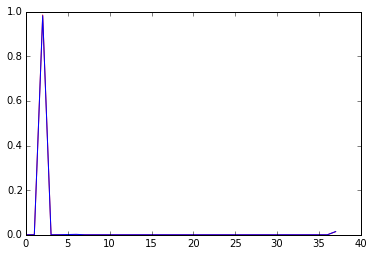

In [50]:
n = 31
print(valid_tt[n], proba[n])
plt.plot(proba[n], 'r')
plt.plot(pk7[n])

In [ ]:
plt.plot(pk7[n])

In [ ]:
valid_visits[11]

In [42]:
valid[valid.VisitNumber == valid_visits[23]]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,DepartmentDescriptionInt
5692,26,2082,5,1780014941,1,PETS AND SUPPLIES,241,51


In [ ]:
x = train[train.DepartmentDescriptionInt==17].TripType
x.value_counts()

In [35]:
len(np.unique(train[train.TripType == 5].VisitNumber))/len(np.unique(train.VisitNumber))

0.12726357070912714

In [151]:
pcomb = ((pk7 * .65) + proba) / 1.65
#pcomb = (pk7 + proba) / 2

print(multiclass_log_loss(valid_tt, pcomb))
for i in range(0,len(valid_tt)):
#for i in range(0,20):    
    if np.argmax(proba[i]) == np.argmax(pk7[i]):
        am = np.argmax(proba[i])
        
#        print(i, proba[i][am], pk7[i][am])
        
        if (proba[i][am] > .9995) and (pk7[i][am] > 0.95):
            for j in range(0, 38):
                pcomb[i][j] = 0
                
            pcomb[i][am] = 1
#            pcomb[i] = proba[i]

print(multiclass_log_loss(valid_tt, pcomb))

#print(multiclass_log_loss(valid_tt[0:100], pcomb[0:100]))
        

0.605894349139
0.605702190026


In [54]:
np.argmax(proba[23]), np.argmax(pk7[23])

(5, 5)

In [55]:
valid_tt[23]

26.0

0.082517773

In [94]:
np.exp(np.log(proba[300])+np.log(pk7[300]))

array([  7.68478860e-14,   8.65101722e-14,   1.07418596e-10,
         6.12968021e-11,   1.86579566e-11,   1.14738953e-16,
         3.46423176e-16,   1.24733052e-10,   2.09441988e-11,
         1.52292776e-08,   1.12588205e-12,   1.34149354e-10,
         3.12454949e-12,   1.03647752e-10,   4.11650726e-10,
         1.86498341e-12,   1.65244475e-06,   1.57323790e-09,
         3.08705500e-10,   1.03409257e-11,   2.41012829e-12,
         2.50329903e-12,   1.95257724e-11,   9.37174016e-12,
         7.19651806e-11,   8.09177958e-11,   5.14329832e-12,
         1.80093218e-09,   1.66213716e-09,   1.10761504e-05,
         3.60268417e-07,   4.23912524e-06,   9.31800715e-01,
         4.23038900e-11,   1.05679024e-10,   2.14781861e-10,
         1.87316643e-07,   9.55049203e-09])

In [95]:
proba[300]

array([  6.01559194e-08,   3.53653121e-07,   2.07200173e-06,
         6.99457996e-06,   5.00389952e-08,   3.39423216e-12,
         3.79982504e-11,   2.37403947e-06,   5.95450229e-06,
         5.10793143e-05,   2.65962115e-07,   8.11497739e-06,
         6.91792138e-07,   1.23058123e-06,   1.83848006e-05,
         5.30198463e-07,   3.59976490e-04,   4.20997048e-06,
         5.92997594e-06,   7.49576657e-07,   1.15949661e-06,
         3.86303356e-07,   6.85180964e-07,   1.81096891e-06,
         7.05024888e-07,   9.18821002e-07,   1.38583380e-06,
         1.03739094e-05,   7.52144206e-06,   1.62198429e-03,
         1.04672908e-04,   1.21289253e-04,   9.97633576e-01,
         1.68442980e-07,   2.18852733e-07,   1.79967884e-07,
         1.75625701e-05,   6.17552178e-06])